# Real-time detection of anomaly signal of weather data using GAN

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy as sp
import os
from tqdm import tnrange

### The data for preliminary analysis contains two years observation weather data from 38 currently working stations in Pennsylvania and consists over million time-series with 90 columns of hourly, daily and monthly observed values. For simplicity, I mangled data containing only dry bulb temperature value with 38 station columns and over 18000 hourly lines of 2018 and 2017 to train GAN.

In [2]:
datadir = "/media/jeong/Linux_DATA/data/"

def remove_str(x):
    str_filter = re.compile("^[-+0-9.]")
    x = ''.join(list(filter(str_filter.match, str(x))))
    if len(x)==0:
        x = np.NAN
    return x

r = re.compile('HOURLY.*')

In [3]:
def hourly_data_process(f_idx, year):
    df_test = []
    for f_id in f_idx:
        df_test.append(pd.read_csv(datadir + 'incubator/NOAA/' + str(f_id) + '.csv', low_memory=False))
    df_final = pd.concat(df_test)

    df_drytemp = df_final[['DATE', 'STATION', 'HOURLYDRYBULBTEMPC']]
    df_drytemp.loc[:, 'HOURLYDRYBULBTEMPC'] = df_drytemp.HOURLYDRYBULBTEMPC.apply(remove_str)
    df_drytemp = df_drytemp[df_final.HOURLYDRYBULBTEMPC.notna()]
    df_drytemp.loc[:, 'HOURLYDRYBULBTEMPC'] = df_drytemp.HOURLYDRYBULBTEMPC.astype(float).values

    r = re.compile('HOURLY.*')
    sel_col_name = list(filter(r.match, df_drytemp.columns))

    df_drytemp['NEW_DATE'] = pd.to_datetime(df_drytemp.DATE).apply(lambda x: (x - pd.to_datetime(str(year) + '-01-01 00:00'))//3600000000000).astype(int)

    df_pivot = df_drytemp.pivot_table(index=['STATION'], columns=['NEW_DATE'], values='HOURLYDRYBULBTEMPC')

    for i in df_pivot.columns.values:
        df_pivot[i] = df_pivot[i].fillna(df_pivot[i].mean())

    df_pivot = df_pivot.T
    df_pivot.to_csv(datadir + 'incubator/NOAA/' + 'PEN' + str(year) + '.csv')

In [4]:
f_2017_idx = [1597037, 1597038, 1597039, 1597040]
f_2018_idx = [1596652, 1596691, 1596696, 1596958, 1597046]

In [5]:
hourly_data_process(f_2018_idx, 2018)
hourly_data_process(f_2017_idx, 2017)

/home/jeong/.env/tensorflow/lib/python3.5/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# Forecast GAN

### GAN consists with two parts, discriminator and generator. In this forecast GAN, the generator is trained to predict the dry temperature data of 't+3' slice only from 't'~'t+2' slice input. The discriminator gets the temperature data of 't+3' slice as true observed data or predicted synthetic data along with 't'~'t+2' data. The discriminator judges if the last slice of data is from generator or real value.

In [6]:
###

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Allocated memory of GPU grow
K.set_session(tf.Session(config=config))

In [8]:

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:
# Discriminator Net
X1 = tf.placeholder(tf.float32, shape=[None, 114], name='X1')
X2 = tf.placeholder(tf.float32, shape=[None, 38], name='X2')

D_W1 = tf.get_variable('D_W1', shape=[152, 512], 
                       initializer=tf.glorot_uniform_initializer())
D_b1 = tf.get_variable('D_b1', shape=[512], 
                       initializer=tf.glorot_uniform_initializer())
#D_W2 = tf.get_variable('D_W2', shape=[512, 512], 
#                       initializer=tf.glorot_uniform_initializer())
#D_b2 = tf.get_variable('D_b2', shape=[512], 
#                       initializer=tf.glorot_uniform_initializer())
D_W3 = tf.get_variable('D_W2', shape=[512, 1], 
                       initializer=tf.glorot_uniform_initializer())
D_b3 = tf.get_variable('D_b2', shape=[1], 
                       initializer=tf.glorot_uniform_initializer())

#theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

theta_D = [D_W1, D_W3, D_b1, D_b3]

# Generator Net

G_W1 = tf.get_variable('G_W1', shape=[114, 128], 
                       initializer=tf.glorot_uniform_initializer())
G_b1 = tf.get_variable('G_b1', shape=[128], 
                       initializer=tf.glorot_uniform_initializer())
G_W2 = tf.get_variable('G_W2', shape=[128, 128], 
                       initializer=tf.glorot_uniform_initializer())
G_b2 = tf.get_variable('G_b2', shape=[128], 
                       initializer=tf.glorot_uniform_initializer())
G_W3 = tf.get_variable('G_W3', shape=[128, 38], 
                       initializer=tf.glorot_uniform_initializer())
G_b3 = tf.get_variable('G_b3', shape=[38], 
                       initializer=tf.glorot_uniform_initializer())

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]


def discriminator(x1, x2):
    x = tf.concat([x1, x2], 1)
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
#    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
#    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_logit = tf.matmul(D_h1, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def generator(x1):
    G_h1 = tf.nn.relu(tf.matmul(x1, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_log_prob = tf.matmul(G_h2, G_W3) + G_b3
    #G_prob = tf.nn.relu(G_log_prob)
    G_prob = G_log_prob

    return G_prob


def fD(x1, x2, g_z):
    D_real, D_logit_real = discriminator(x1, x2)
    D_fake, D_logit_fake = discriminator(x1, g_z)
    D_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real))
    D_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake))
    return D_loss_real + D_loss_fake


G_sample = generator(X1)

#D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
#G_loss = -tf.reduce_mean(tf.log(D_fake))
# Alternative losses:
# -------------------

D_fake0, D_logit_fake0 = discriminator(X1, G_sample)

D_loss = tf.reduce_mean(fD(X1, X2, G_sample))
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake0, labels=tf.ones_like(D_logit_fake0)))

# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

mb_size=64 # minibatch

D_loss_stack = []
G_loss_stack = []
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Use temperature data of 2018 to train forecast GAN network.

In [10]:
df_pen2018 = pd.read_csv(datadir + 'incubator/NOAA/' + 'PEN2018.csv', index_col='NEW_DATE')

X_train = []
X_real = []
# Random selection of time slices
idx = np.arange(len(df_pen2018)-3)
np.random.shuffle(idx)

for k in idx:
    X_train.append(df_pen2018.iloc[k:k+3].values.flatten())
    X_real.append(df_pen2018.iloc[k+3].values.flatten())

n_learn = 1000000

In [11]:
for it in tnrange(n_learn, desc='GAN'):
    idxs = np.random.choice(len(df_pen2018)-3, mb_size)
    X_train_0 = [X_train[x] for x in idxs]
    X_real_0 = [X_real[x] for x in idxs]

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X1: X_train_0, X2: X_real_0})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X1: X_train_0})
    D_loss_stack.append(D_loss_curr)
    G_loss_stack.append(G_loss_curr)

### Pic1. The loss functions are adversarial. Since we use limited number of training set, both of loss functions are decreasing. When we train this model with fluent data set, the picture will show adversarial relation between values of loss functions. 

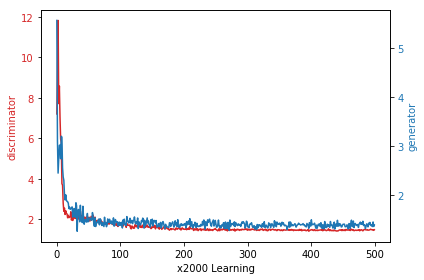

In [12]:
n_stack = len(D_loss_stack)
plt_pts = 500
t = range(plt_pts)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('x' + str(n_stack//plt_pts) + ' Learning')
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('discriminator', color=color)
ax1.plot(t, np.mean(np.array(D_loss_stack).reshape(plt_pts,n_stack//plt_pts), axis=1), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('generator', color=color)  # we already handled the x-label with ax1
ax2.plot(t, np.mean(np.array(G_loss_stack).reshape(plt_pts,n_stack//plt_pts), axis=1), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# test 2017

## Test with the data of 2017
### Predict the last slice of sequential time data using GAN network which is trained with the 2018 data

In [13]:
df_2017 = pd.read_csv(datadir + 'incubator/NOAA/' + 'PEN2017.csv', index_col='NEW_DATE')

X_test = []
X_ground = []
idx = np.arange(len(df_2017)-3)
np.random.shuffle(idx)
for k in idx:
    X_test.append(df_2017.iloc[k:k+3].values.flatten())
    X_ground.append(df_2017.iloc[k+3].values)

# t-sne

## Test how much similar the predicted data with ground truth

In [14]:
t_sne_idx = np.random.choice(len(df_2017)-3, 200)
input_set = [X_test[i] for i in t_sne_idx]
real_set = [X_ground[i] for i in t_sne_idx]
predicted_set = sess.run(generator(X1), feed_dict={X1 : input_set})

df_real = pd.DataFrame(real_set)
df_predicted = pd.DataFrame(predicted_set)
df_real.columns = df_2017.columns
df_predicted.columns = df_2017.columns
df_real['real'] = 1
df_predicted['real'] = 0

df_tsne = df_real.append(df_predicted)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(df_tsne.drop(['real'], axis=1))

### Pic2. The picture shows us that predicted(green) points mimic points of real data set. While, in the right bottom region, predicted points are a bit skewed from real data point, in the left top, predicted points are much similar with real values. 

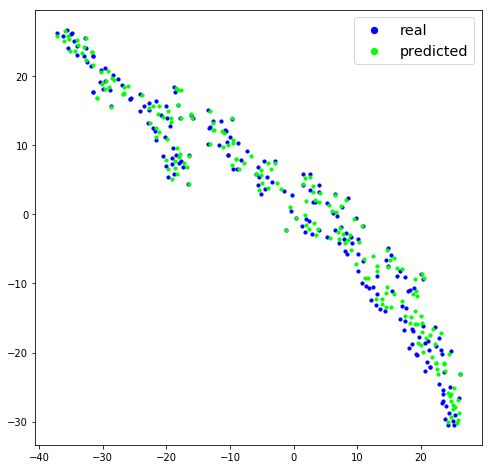

In [15]:
color_intermediates = df_tsne['real'].values
real_tsne = intermediates_tsne[color_intermediates==1]
predicted_tsne = intermediates_tsne[color_intermediates==0]
plt.figure(figsize=(8, 8))
plt.scatter(x=real_tsne[:,0], 
            y=real_tsne[:,1], s=10, 
            c='blue', 
            alpha=1., label='real')
plt.scatter(x=predicted_tsne[:,0], 
            y=predicted_tsne[:,1], s=10, 
            c='lime', 
            alpha=1, label='predicted')
plt.legend(loc='upper right', markerscale=2, fontsize='x-large')
plt.show()

#df_allfeats['tsne0'] = intermediates_tsne[:,0]
#df_allfeats['tsne1'] = intermediates_tsne[:,1]

# Pic

### Following pictures are temperature maps of given time slice. Upper 4-pictures are drawn with real temperature data of each time slice and lower 1 picture is temperature predicted map with forecast GAN based on upper 't'~'t+2' input values.

In [16]:
from scipy.interpolate import griddata
coord = pd.read_csv(datadir + 'incubator/NOAA/' + 'PEN_station.csv', index_col='STATION')
grid_x, grid_y = np.mgrid[-80.5:-75.0:100j, 39.6:42.1:100j]
x_coord = grid_x[:,0]
y_coord = grid_x[0,:]

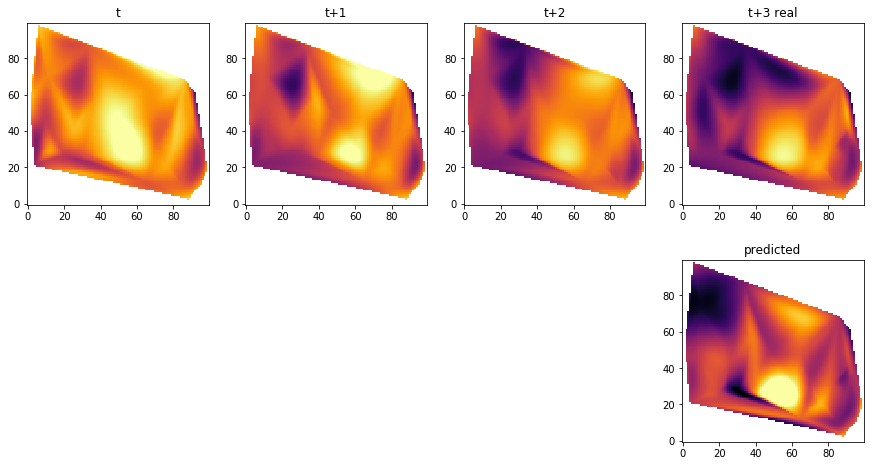

In [17]:
rand_idx = np.random.randint(200)
pics = np.hstack([input_set[rand_idx], real_set[rand_idx], predicted_set[rand_idx]]).reshape(5,len(coord))

grid_z = []
for pic in pics:
    grid_z.append(griddata(coord.values, pic, (grid_x, grid_y), method='cubic'))

v_min = pics.min()
v_max = pics.max()

label = ['t', 't+1', 't+2', 't+3 real', 'predicted']
for i in range(5):
    if i==4:
        j=8
    else:
        j=i+1
    plt.subplot(2,4,j)
    plt.imshow(grid_z[i].T, origin='lower', vmin=v_min, vmax=v_max, cmap='inferno')
    plt.title(label[i])
plt.gcf().set_size_inches(15, 8)
plt.show()